In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
import re
import requests
import time
from datetime import datetime
from datetime import timezone
import csv
import mwparserfromhell
import sys
import tqdm

In [3]:
df = pd.read_csv('../../datas/final/large_db_preprocess.csv')
articles = sorted(df['article'].unique().tolist())

In [4]:
articles

['2004 Ukrainian presidential election',
 '2014 pro-Russian unrest in Ukraine',
 '2022 Russian invasion of Ukraine',
 'Abortion in Ukraine',
 'Administrative divisions of Ukraine',
 'Alexander II of Russia',
 'Armed Forces of Ukraine',
 'Bessarabia',
 'Buddhism in Ukraine',
 'Bukovina',
 'COVID-19 pandemic in Ukraine',
 'Catherine the Great',
 'Censuses in Ukraine',
 'Christianity in Russia',
 'Christmas in Ukraine',
 'Communist Party of the Soviet Union',
 'Crimea',
 'Crimean Tatars',
 'Culture of Ukraine',
 'Demographics of Ukraine',
 'Dissolution of the Soviet Union',
 'Eastern Front (World War I)',
 'Eastern Front (World War II)',
 'Economy of Ukraine',
 'Education in Ukraine',
 'Epiphanius I of Ukraine',
 'Euromaidan',
 'Flag of Ukraine',
 'Football in Ukraine',
 'Foreign relations of Ukraine',
 'Galicia (Eastern Europe)',
 'Geography of Ukraine',
 'Government of Ukraine',
 "Government of the Ukrainian People's Republic in exile",
 'History of Christianity in Ukraine',
 'History o

## Protection Status

In [5]:
URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

# -------------------------
# API FOR PROTECTION STATUS
# -------------------------

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer"    # first revision = creation
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }


def get_article_protection_status(article_title):
    """
    Get the protection staturs of an article
    The status can be :
    - fully protected 
    - semi-protected
    - template protected
    - ...
    """
    
    session = requests.Session()
    session.headers.update(HEADERS)

    params = {
        "action": "query",
        "titles": article_title,
        "prop": "info",
        "inprop": "protection",
        "format": "json"
    }

    response = requests.get(url=URL, params=params, headers=HEADERS)
    data = response.json()

    # Extract page object (the pageid is unknown => key is not fixed)
    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return {"status": "missing", "protections": []}

    protections = page.get("protection", [])

    # If no protection entries → page is fully open
    if not protections:
        return {"status": "unprotected", "protections": []} 

    # Convert the protection status to understand better
    status = "custom protection"
    for prot in protections:
        action = prot.get("type")
        level = prot.get("level")

        if action == "edit":
            if level == "autoconfirmed":
                status = "semi-protected"
            elif level == "extendedconfirmed":
                status = "extended-protected"
            elif level == "sysop":
                status = "fully protected"
        elif action == "move" and level == "sysop":
            status = "move-protected"

    return {
        "status": status,
        "protections": protections  # raw list for further analysis
    }

def get_article_protection_history(article_title):
    """
    Retrieve the full protection history of an article using MediaWiki logevents.
    Returns a sorted list of protection events including timestamp, action,
    protection levels, expiry, and comments.
    """

    session = requests.Session()
    session.headers.update(HEADERS)

    events = []
    cont = {}

    while True:
        params = {
            "action": "query",
            "list": "logevents",
            "letype": "protect",
            "letitle": article_title,
            "lelimit": "max",
            "format": "json",
            **cont
        }

        response = session.get(URL, params=params)
        data = response.json()

        for ev in data["query"]["logevents"]:
            event = {
                "timestamp": ev.get("timestamp"),
                "user": ev.get("user"),
                "action": ev.get("action"),        # protect / modify / unprotect / move_prot
                "comment": ev.get("comment"),

                # details with levels and expiry (may be missing)
                "protection": ev.get("params", {}).get("details", []),
            }
            events.append(event)

        # Continue if there's more data
        if "continue" in data:
            cont = data["continue"]
        else:
            break

    # Sort chronologically
    events.sort(key=lambda x: x["timestamp"])

    return events

# -----------------------------
# METHODS FOR PROTECTION STATUS 
# -----------------------------

    # -------
    # HELPERS
    # -------

def parse_old_protection(comment):
    """
    Extracts old-style MediaWiki protection settings from a log comment.
    Example: "edit war [edit=sysop:move=sysop]"
    Returns dict: {"edit": "sysop", "move": "sysop"}
    """
    match = re.search(r"\[(.*?)\]", comment)
    if not match:
        return {}

    content = match.group(1)
    rules = content.split(":")

    prot = {}
    for rule in rules:
        if "=" in rule:
            key, value = rule.split("=", 1)
            prot[key.strip()] = value.strip()

    return prot


def resolve_status(prot_dict):
    """
    Convert a dict of edit/move protection settings to a unified status string.
    Used for new-style AND old-style protections.
    """
    edit = prot_dict.get("edit")
    move = prot_dict.get("move")

    if edit == "sysop":
        return "fully protected"
    if edit == "extendedconfirmed":
        return "extended-protected"
    if edit == "autoconfirmed":
        return "semi-protected"
    if move == "sysop":
        return "move-protected"

    return "unprotected"


    # --------------
    # BUILD TIMELINE
    # --------------

def build_protection_timeline(article_title):
    """
    Build chronological protection timeline with:
      - new-style MW protection data (post-2010)
      - old-style comment-embedded protection info (pre-2010)

    Output:
        [
          {"start": datetime, "end": datetime, "status": "unprotected"},
          {"start": datetime, "end": datetime, "status": "semi-protected"},
          ...
        ]
    """

    events = get_article_protection_history(article_title)

    # If no protection events at all → always unprotected
    if not events:
        # Try to use creation date if available; otherwise return None/None
        creation_info = get_article_creation_date(article_title)
        if creation_info and "timestamp" in creation_info:
            creation_dt = datetime.fromisoformat(
                creation_info["timestamp"].replace("Z", "+00:00")
            )
            return [{
                "start": creation_dt,
                "end": datetime.utcnow(),
                "status": "unprotected"
            }]
        else:
            return [{
                "start": None,
                "end": None,
                "status": "unprotected"
            }]

    # --- Initial state: article just born, unprotected ---
    creation_info = get_article_creation_date(article_title)
    creation_dt = datetime.fromisoformat(
        creation_info["timestamp"].replace("Z", "+00:00")
    )

    timeline = []
    current_status = "unprotected"
    current_start = creation_dt

    # events should already be chronological, but just to be safe:
    events = sorted(events, key=lambda e: e["timestamp"])

    for ev in events:
        timestamp = datetime.fromisoformat(ev["timestamp"].replace("Z", "+00:00"))
        action = ev.get("action")
        protections = ev.get("protection", [])
        comment = ev.get("comment", "")
        
        
        expiry_dates = []
        for p in protections:
            expiry = p.get('expiry')
            if expiry and expiry != 'infinite':
                expiry_dates.append(datetime.fromisoformat(expiry.replace('Z', '+00:00')))

        expiry_dt = min(expiry_dates) if expiry_dates else None

        # Start by assuming status stays the same
        new_status = current_status

        # --- CASE 1: explicit unprotect ---
        if action == "unprotect":
            new_status = "unprotected"

        # --- CASE 2: protect / modify / move_prot → set some level ---
        elif action in ("protect", "modify", "move_prot", "move_protect"):
            prot_dict = {}

            # (1) Try new-style protection entries from API
            for prot in protections:
                ptype = prot.get("type")   # "edit", "move", ...
                level = prot.get("level")  # "sysop", "autoconfirmed", ...
                if ptype and level:
                    prot_dict[ptype] = level

            # (2) If nothing found → try old-style [edit=sysop:move=sysop]
            if not prot_dict:
                old = parse_old_protection(comment)
                prot_dict.update(old)

            # (3) Resolve final status from prot_dict
            new_status = resolve_status(prot_dict)

        # else: action not recognised (rare) → keep current_status

        # --- If status changed, close previous interval and start a new one ---
        if new_status != current_status:
            # close previous interval
            timeline.append({
                "start": current_start,
                "end": timestamp,
                "status": current_status
            })

            # start new interval
            current_status = new_status
            current_start = timestamp
            

        if expiry_dt:
            # Close current interval at expiry
            timeline.append({
                "start": current_start,
                "end": expiry_dt,
                "status": current_status
            })

            # After expiry, status becomes unprotected until next event
            current_status = "unprotected"
            current_start = expiry_dt

    # Close the last interval, ending at "now"
    timeline.append({
        "start": current_start,
        "end": datetime.utcnow(),
        "status": current_status
    })

    return timeline

    # --------------
    # PLOT TIMELINES
    # --------------

def plot_protection_timelines(timelines, wanna_save_fig = False):
    
    """
    Gantt-style plot for multiple articles.
    timelines: dict => {article_name: [intervals]}
    """

    PROTECTION_COLORS = {
    "unprotected": "#C0C0C0",
    "semi-protected": "#1f77b4",
    "extended-protected": "#ff7f0e",
    "fully protected": "#d62728",
    }
    
    articles = sorted(timelines.keys())  # alphabetical
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        intervals = timelines[article]

        for interval in intervals:
            start = interval["start"]
            end = interval["end"]
            status = interval["status"]

            if start is None or end is None:
                continue

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=PROTECTION_COLORS.get(status, "black"),
                edgecolor="none"
            )

        ax.text(
            mdates.date2num(intervals[0]["start"]) - 50, 
            y_pos + height / 2,
            article, va="center", ha="right"
        )

        y_pos += 1

    # --- remove black frame / spines ---
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- add legend ---
    legend_handles = [
        Patch(facecolor=color, label=status)
        for status, color in PROTECTION_COLORS.items()
    ]
    ax.legend(
        handles=legend_handles,
        title="Protection Status",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Protection Evolution Timeline (40 Articles)", fontsize=14)
    plt.tight_layout()
    if wanna_save_fig:
        fig_title = 'Wikipedia Protection Evolution Timeline (40 Articles)'
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches='tight')
    plt.show()

def timelines_to_dataframe(timelines):
    """
    Convert the timelines dict into a pandas DataFrame with:
    article | start | end | status | diff (days)
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, intervals in timelines.items():
        for interval in intervals:
            start = interval["start"]
            end = interval["end"]
            status = interval["status"]

            # Normalize timezone to UTC
            if start is not None:
                if start.tzinfo is None:
                    start = start.replace(tzinfo=timezone.utc)
                else:
                    start = start.astimezone(timezone.utc)

            if end is not None:
                if end.tzinfo is None:
                    end = end.replace(tzinfo=timezone.utc)
                else:
                    end = end.astimezone(timezone.utc)

            # Compute difference in days
            diff_days = (end - start).days if start and end else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "status": status,
                "diff": diff_days
            })

    return pd.DataFrame(rows)

In [10]:
protection_timelines = {} # needed to build the timelines and build the plot 
protection_hist = {} # needed to check if the results of 'timelines' is good

for title in articles:
    protection_timelines[title] = build_protection_timeline(title)
    protection_hist[title] = get_article_protection_history(title)
    
df_protect = timelines_to_dataframe(protection_timelines)

In [14]:
df_protect[df_protect['article'] == '2022 Russian invasion of Ukraine']

,article,start,end,status,diff
2,2022 Russian invasion of Ukraine,2025-03-07 03:47:22+00:00,2022-02-24 04:10:47+00:00,unprotected,-1107
3,2022 Russian invasion of Ukraine,2022-02-24 04:10:47+00:00,2022-02-26 04:10:47+00:00,semi-protected,2
4,2022 Russian invasion of Ukraine,2022-02-26 04:10:47+00:00,2022-02-24 18:46:08+00:00,unprotected,-2
5,2022 Russian invasion of Ukraine,2022-02-24 18:46:08+00:00,2023-02-24 18:46:08+00:00,extended-protected,365
6,2022 Russian invasion of Ukraine,2023-02-24 18:46:08+00:00,2022-03-17 14:42:02+00:00,unprotected,-345
7,2022 Russian invasion of Ukraine,2022-03-17 14:42:02+00:00,2023-02-24 18:46:08+00:00,extended-protected,344
8,2022 Russian invasion of Ukraine,2023-02-24 18:46:08+00:00,2023-02-25 18:59:53+00:00,unprotected,1
9,2022 Russian invasion of Ukraine,2023-02-25 18:59:53+00:00,2024-02-25 18:59:53+00:00,extended-protected,365
10,2022 Russian invasion of Ukraine,2024-02-25 18:59:53+00:00,2024-02-26 00:37:09+00:00,unprotected,0
11,2022 Russian invasion of Ukraine,2024-02-26 00:37:09+00:00,2026-01-09 10:42:04.708363+00:00,extended-protected,683


In [17]:
def clean_protection_df(protect_dataframe):
    df = protect_dataframe.copy()
    df = df.drop(index=[2, 3, 4, 6, 7])
    return df
    
def match_protect_feature_with_df(protect_dataframe, dataframe):

    df = dataframe.copy()
    
    df["date"] = pd.to_datetime(df["date"], utc=True, format="ISO8601")
    df = df.sort_values('date', ascending=False)

    protect_dataframe["start"] = pd.to_datetime(protect_dataframe["start"], utc=True, format="ISO8601")
    protect_dataframe["end"]   = pd.to_datetime(protect_dataframe["end"],   utc=True, format="ISO8601")
    
    for idx, row in df.iterrows():
        article = row["article"]
        date_df = row["date"]    

        protect_subset = protect_dataframe[protect_dataframe["article"] == article]
    
        for _, tp in protect_subset.iterrows():
            protect_start = tp["start"]
            protect_end   = tp["end"]
    
            if protect_start <= date_df < protect_end:
                df.loc[idx, "status"] = tp["status"]
                break    

    return df

df_protect_clean = clean_protection_df(df_protect)
df_match_protect=match_protect_feature_with_df(df_protect_clean, df)

In [18]:
df_match_protect['status'].unique()

array(['unprotected', nan, 'semi-protected', 'extended-protected',
       'fully protected'], dtype=object)

## Importance and Grades Analysis

In [19]:
# Try to store the article's metadata changes in a timeline
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer"    # first revision = creation
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }
    
def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

WIKIPROJECT_RE = re.compile(
    r"\{\{\s*[Ww]ikiProject[^{}]*\}\}",
    re.DOTALL
)

PROJECT_NAME_RE = re.compile(
    r"\{\{\s*[Ww]ikiProject\s*([A-Za-z0-9 _-]+)"
)

CLASS_RE = re.compile(r"\|\s*class\s*=\s*([A-Za-z]+)", re.IGNORECASE)
IMPORTANCE_RE = re.compile(r"\|\s*importance\s*=\s*([A-Za-z]+)", re.IGNORECASE)


def extract_metadata(wikitext):
    """
    Extract class + importance from WikiProject Ukraine if possible.
    Otherwise fallback to the first WikiProject template.
    """

    ukraine_template = None
    first_template = None

    # --- 1. Scan all WikiProject templates ---
    for template in WIKIPROJECT_RE.findall(wikitext):

        # Store the first template if not set yet
        if first_template is None:
            first_template = template

        # Extract the WikiProject name (e.g., 'Ukraine')
        project_match = PROJECT_NAME_RE.search(template)
        if not project_match:
            continue

        project_name = project_match.group(1).strip().lower()

        # If it's WikiProject Ukraine → prioritize it
        if "ukraine" in project_name:
            ukraine_template = template

    # --- 2. Choose the correct template ---
    chosen_template = ukraine_template or first_template
    class_rating = None
    importance_rating = None

    if chosen_template:
        class_match = CLASS_RE.search(chosen_template)
        if class_match:
            class_rating = class_match.group(1).upper()

        imp_match = IMPORTANCE_RE.search(chosen_template)
        if imp_match:
            importance_rating = imp_match.group(1).capitalize()

    return {
        "class": class_rating,
        "importance": importance_rating,
    }

def build_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"class": None, "importance": None}

    for rev in talk_revisions:
        meta = extract_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline    

def extract_article_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline

def plot_grade_quality_change(timelines, wanna_save_fig=False):
    """
    Gantt-style timeline representing quality-class evolution.
    `timelines` is a dict:
        { article : [ {timestamp, end, class}, ... ] }
    """

    # --- Colors used for classes ---
    GRADE_COLORS = {
        "FA": "navy",
        "FL": "royalblue",
        "A": "darkgreen",
        "GA": "green",
        "B": "limegreen",
        "C": "gold",
        "START": "orange",
        "STUB": "indianred",
        None: "lightgray",
    }

    articles = sorted(timelines.keys())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        tl = timelines[article]

        if len(tl) == 0:
            y_pos += 1
            continue

        # Convert to DataFrame and build intervals
        df = pd.DataFrame(tl)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        
        # Compute next timestamp
        df["end"] = df["timestamp"].shift(-1)
        
        # Ensure the last interval ends at NOW (UTC)
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz="UTC"))

        # For each interval, plot using broken_barh
        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            cls = row["class"]

            if pd.isna(start) or pd.isna(end):
                continue

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=GRADE_COLORS.get(cls, "black"),
                edgecolor="none"
            )

        # Add article label aligned left of first segment
        ax.text(
            mdates.date2num(df["timestamp"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Legend
    legend_handles = [
        Patch(facecolor=color, label=label)
        for label, color in GRADE_COLORS.items() if label is not None
    ]
    ax.legend(
        handles=legend_handles,
        title="Quality Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Quality Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig(
            "../../plots/Full Database/quality_timeline.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

def plot_importance_change(timelines, wanna_save_fig=False):
    """
    Gantt-style timeline representing importance-class evolution.
    `timelines` is a dict:
        { article : [ {timestamp, end, importance}, ... ] }

    importance ∈ {"Top", "High", "Mid", "Low", None}
    """

    # --- Colors used for IMPORTANCE classes ---
    IMPORTANCE_COLORS = {
        "Top": "darkblue", 
        "High": "#0052A3", 
        "Mid": "#5CADFF", 
        "Low": "#B8DBFF", 
        None: "lightgray",
    }

    articles = sorted(timelines.keys())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.4))

    y_pos = 0
    height = 0.8

    for article in articles:
        tl = timelines[article]

        if len(tl) == 0:
            y_pos += 1
            continue

        df = pd.DataFrame(tl)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Compute next interval end
        df["end"] = df["timestamp"].shift(-1)
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz="UTC"))

        # Plot each interval
        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            imp = row["importance"]

            if pd.isna(start) or pd.isna(end):
                continue

            ax.broken_barh(
                [(mdates.date2num(start),
                  mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=IMPORTANCE_COLORS.get(imp, "black"),
                edgecolor="none"
            )

        # Left-side article label
        ax.text(
            mdates.date2num(df["timestamp"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    # --- Style cleanup ---
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Legend ---
    legend_handles = [
        Patch(facecolor=color, label=label if label is not None else "None")
        for label, color in IMPORTANCE_COLORS.items()
    ]

    ax.legend(
        handles=legend_handles,
        title="Importance Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Importance Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig("../../plots/Full Database/importance_timeline.png", dpi=300, bbox_inches="tight")

    plt.show()

def grade_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, changes in timelines.items():
        if len(changes) == 0:
            continue

        # Convert to dataframe for easier shifting
        df = pd.DataFrame(changes)

        # Normalize timestamps to UTC-aware datetimes
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Create `end` by shifting
        df["end"] = df["timestamp"].shift(-1)

        # Last interval ends at "now" in UTC
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz=timezone.utc))

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            grade = row["class"]

            # Compute duration in days
            diff_days = (end - start).days if (start is not None and end is not None) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "grade": grade,
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

def importance_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, changes in timelines.items():
        if len(changes) == 0:
            continue

        # Convert to dataframe for easier shifting
        df = pd.DataFrame(changes)

        # Normalize timestamps to UTC-aware datetimes
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        # Create `end` by shifting
        df["end"] = df["timestamp"].shift(-1)

        # Last interval ends at "now" in UTC
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz=timezone.utc))

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            importance = row["importance"]

            # Compute duration in days
            diff_days = (end - start).days if (start is not None and end is not None) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "importance": importance,
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

In [20]:
importance_grade_timelines = {} # needed to build the timelines and build the plot 

for title in articles:
    importance_grade_timelines[title] = extract_article_metadata_timeline(title)

importance_grade_timelines


=== Fetching Talk Page revisions for: 2004 Ukrainian presidential election ===
Fetched 89 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: 2014 pro-Russian unrest in Ukraine ===
Fetched 3241 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 10

=== Fetching Talk Page revisions for: 2022 Russian invasion of Ukraine ===
Fetched 260 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 1

=== Fetching Talk Page revisions for: Abortion in Ukraine ===
Fetched 15 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 5

=== Fetching Talk Page revisions for: Administrative divisions of Ukraine ===
Fetched 245 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: Alexander II of Russia ===
Fetched 134 talk revisions.
=== Parsing metadata changes (Option B) 

{'2004 Ukrainian presidential election': [{'timestamp': '2007-04-13T21:12:49Z',
   'rev_id': 122590665,
   'class': 'B',
   'importance': 'High'},
  {'timestamp': '2025-09-30T02:42:32Z',
   'rev_id': 1314170590,
   'class': None,
   'importance': 'High'}],
 '2014 pro-Russian unrest in Ukraine': [{'timestamp': '2014-03-11T02:32:47Z',
   'rev_id': 599077684,
   'class': 'C',
   'importance': 'Mid'},
  {'timestamp': '2014-05-29T08:25:51Z',
   'rev_id': 610609864,
   'class': 'C',
   'importance': 'Top'},
  {'timestamp': '2014-06-01T23:38:41Z',
   'rev_id': 611154394,
   'class': None,
   'importance': None},
  {'timestamp': '2014-06-01T23:39:09Z',
   'rev_id': 611154447,
   'class': 'C',
   'importance': 'Top'},
  {'timestamp': '2014-06-01T23:39:57Z',
   'rev_id': 611154540,
   'class': None,
   'importance': None},
  {'timestamp': '2014-06-01T23:43:03Z',
   'rev_id': 611154884,
   'class': 'C',
   'importance': 'Top'},
  {'timestamp': '2023-08-05T20:53:45Z',
   'rev_id': 1168907250,
   '

In [78]:
importance_df = importance_timelines_to_dataframe(importance_grade_timelines)
def clean_importance_df(dataframe):
    df = dataframe.copy()
    df['importance'] = (
    df['importance']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

importance_df = clean_importance_df(importance_df)
importance_df

,article,start,end,importance,diff_days
0,2004 Ukrainian presidential election,2007-04-13 21:12:49+00:00,2025-09-30 02:42:32+00:00,High,6744
1,2004 Ukrainian presidential election,2025-09-30 02:42:32+00:00,2026-01-09 13:29:44.951051+00:00,High,101
2,2014 pro-Russian unrest in Ukraine,2014-03-11 02:32:47+00:00,2014-05-29 08:25:51+00:00,Mid,79
3,2014 pro-Russian unrest in Ukraine,2014-05-29 08:25:51+00:00,2014-06-01 23:38:41+00:00,Top,3
4,2014 pro-Russian unrest in Ukraine,2014-06-01 23:38:41+00:00,2014-06-01 23:39:09+00:00,Unspecified,0
...,...,...,...,...,...
154,History of Ukraine,2022-04-24 02:59:50+00:00,2022-04-24 03:00:22+00:00,Unspecified,0
155,History of Ukraine,2022-04-24 03:00:22+00:00,2024-01-07 04:29:13+00:00,Top,623
156,History of Ukraine,2024-01-07 04:29:13+00:00,2026-01-09 13:29:44.984020+00:00,Top,733
157,History of the Russian Orthodox Church,2011-07-03 01:09:42+00:00,2024-02-15 03:46:41+00:00,Top,4610


In [70]:
grade_df = grade_timelines_to_dataframe(importance_grade_timelines)
def clean_grade_df(dataframe):
    df = dataframe.copy()
    df['grade'] = (
    df['grade']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

grade_df = clean_grade_df(grade_df)

## Vital Level

In [45]:
# Try to store the article's metadata changes in a timeline
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

# Regex patterns for vital level of an article
VITAL_RE = re.compile(
    r"""\{\{\s*
        (?:Vital(?:\s+article)?)       
        \s*
        \|
        (?:
            level\s*=\s*([0-9])        
            |
            ([0-9])                    
        )
        .*?
        \}\}""",
    re.IGNORECASE | re.VERBOSE | re.DOTALL
)

VITAL_TEMPLATE_RE = re.compile(
    r"\{\{\s*Vital(?: article)?\s*\|[^}]*?(?:level\s*=\s*([0-9])|([0-9]))",
    re.IGNORECASE | re.DOTALL,
)

VITAL_PARAM_RE = re.compile(
    r"\|\s*(?:vital|vital[-_]?(?:article|level|importance)|va)\s*=\s*([0-9]|yes)",
    re.IGNORECASE,
)


def extract_vital_metadata(wikitext):
    """Extract vital-level metadata from a talk page revision."""

    vital_rating = None

    # 1. Check explicit {{Vital article}} templates
    for match in VITAL_TEMPLATE_RE.finditer(wikitext):
        lvl_named, lvl_positional = match.groups()
        lvl = lvl_named or lvl_positional
        if lvl:
            vital_rating = lvl

    # 2. Check |vital=... parameters in banner shell or WikiProjects
    for match in VITAL_PARAM_RE.finditer(wikitext):
        param = match.group(1).strip().lower()

        if param == "yes":
            vital_rating = "5"     # convention
        else:
            vital_rating = param   # numeric 1–5

    return {"vital": vital_rating}


def build_vital_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"vital": None}

    for rev in talk_revisions:
        meta = extract_vital_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline

def extract_article_vital_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_vital_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline


def vital_timelines_to_dataframe(timelines):
    """
    Convert the vital timelines dict into a pandas DataFrame with:
    article | article_created | start | end | vital | diff_days
    """

    rows = []

    for article, changes in timelines.items():

        creation_info = get_article_creation_date(article)
        if creation_info and "timestamp" in creation_info:
            creation_dt = pd.to_datetime(creation_info["timestamp"], utc=True)
        else:
            creation_dt = pd.NaT

        if len(changes) == 0:
            continue

        df = pd.DataFrame(changes)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

        df["end"] = df["timestamp"].shift(-1)
        df["end"] = df["end"].fillna(pd.Timestamp.now(tz=timezone.utc))

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            vital = row["vital"]

            diff_days = (end - start).days if pd.notnull(start) and pd.notnull(end) else None

            rows.append({
                "article": article,
                "article_created": creation_dt,
                "start": start,
                "end": end,
                "vital": vital,
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

def plot_vital_level_change_from_df(df, wanna_save_fig=False):
    """
    Plot a Gantt-style timeline of Vital Level evolution.
    Input: df with columns
        article | start | end | vital | diff_days
    """

    # --- Colors used for vital levels ---
    GRADE_COLORS = {
        "1": "forestgreen",
        "2": "limegreen",
        "3": "lime",
        "4": "lightseagreen",
        "5": "darkslategray",
        None: "lightgray",   # no vital rating
    }

    # Ensure time columns are datetime
    df = df.copy()
    df["start"] = pd.to_datetime(df["start"], utc=True)
    df["end"]   = pd.to_datetime(df["end"], utc=True)

    # Sort articles alphabetically for consistent plotting order
    articles = sorted(df["article"].unique())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.5))

    y_pos = 0
    height = 0.8

    for article in articles:
        df_a = df[df["article"] == article]

        if df_a.empty:
            y_pos += 1
            continue

        for _, row in df_a.iterrows():
            start = row["start"]
            end   = row["end"]
            vital = row["vital"]
            vital_key = str(vital) if vital is not None else None

            ax.broken_barh(
                [(mdates.date2num(start),
                  mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=GRADE_COLORS.get(vital_key, "black"),
                edgecolor="none"
            )

        # Add article label
        ax.text(
            mdates.date2num(df_a["start"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    # Clean up plot appearance
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Legend (including None)
    legend_handles = [
        Patch(
            facecolor=color,
            label=("None" if label is None else f"Level {label}")
        )
        for label, color in GRADE_COLORS.items()
    ]

    ax.legend(
        handles=legend_handles,
        title="Vital Level",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Vital Level Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig(
            "../../plots/Policy Analysis/vital_level_timeline.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

In [46]:
vital_timelines={}
for article in ['Russian annexation of Crimea', 'Alexander II of Russia', 'History of Ukraine', 'Euromaidan', ' Galicia (Eastern Europe)',
               'Eastern Front (World War I)', 'Eastern Front (World War II)', 'Dissolution of the Soviet Union', 'Crimea', 
               'Communist Party of the Soviet Union', 'Catherine the Great', 'Bessarabia']:
    
    vital_timelines[article] = extract_article_vital_metadata_timeline(article)

vital_timelines


=== Fetching Talk Page revisions for: Russian annexation of Crimea ===
Fetched 5 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: Alexander II of Russia ===
Fetched 134 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 5

=== Fetching Talk Page revisions for: History of Ukraine ===
Fetched 286 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 9

=== Fetching Talk Page revisions for: Euromaidan ===
Fetched 1289 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 1

=== Fetching Talk Page revisions for:  Galicia (Eastern Europe) ===
Fetched 570 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 1

=== Fetching Talk Page revisions for: Eastern Front (World War I) ===
Fetched 134 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 4

=== Fetching Talk 

{'Russian annexation of Crimea': [{'timestamp': '2025-12-13T14:21:31Z',
   'rev_id': 1327258401,
   'vital': '5'},
  {'timestamp': '2025-12-16T14:19:09Z', 'rev_id': 1327860603, 'vital': None}],
 'Alexander II of Russia': [{'timestamp': '2013-12-06T16:46:57Z',
   'rev_id': 584865419,
   'vital': '4'},
  {'timestamp': '2024-01-06T22:45:54Z', 'rev_id': 1194042443, 'vital': '5'},
  {'timestamp': '2024-04-02T14:33:43Z', 'rev_id': 1216878052, 'vital': None},
  {'timestamp': '2024-04-02T16:21:55Z', 'rev_id': 1216895059, 'vital': '4'},
  {'timestamp': '2024-04-03T00:47:02Z', 'rev_id': 1216966203, 'vital': '5'}],
 'History of Ukraine': [{'timestamp': '2013-12-09T16:55:16Z',
   'rev_id': 585298634,
   'vital': '4'},
  {'timestamp': '2022-01-27T13:53:41Z', 'rev_id': 1068264070, 'vital': None},
  {'timestamp': '2022-01-28T11:11:31Z', 'rev_id': 1068430783, 'vital': '4'},
  {'timestamp': '2022-04-24T02:59:50Z', 'rev_id': 1084374145, 'vital': None},
  {'timestamp': '2022-04-24T03:00:22Z', 'rev_id': 1

In [55]:
vital_df = vital_timelines_to_dataframe(vital_timelines)

def clean_vital_df(dataframe):
    df = dataframe.copy()
    df['vital'] = (
    df['vital']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

vital_df = clean_vital_df(vital_df)

In [56]:
vital_df['vital'].unique()

array(['5', 'Unspecified', '4', '3'], dtype=object)

## Match and Plot

In [71]:
def match_features_with_df(grade_dataframe, importance_dataframe, vital_dataframe, dataframe):

    df = dataframe.copy()
    
    # Step 1: convert date column
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df = df.sort_values('date', ascending=False)
    
    # Step 2: assign importance based on timeline intervals
    for idx, row in df.iterrows():
        article = row["article"]
        date_df = row["date"]
    
        # find the timeline rows for this article
        grade_subset      = grade_dataframe[grade_dataframe["article"] == article]
        importance_subset = importance_dataframe[importance_dataframe["article"] == article]
        vital_subset = vital_dataframe[vital_dataframe["article"] == article]
    
        # loop over intervals for this article for grade_dataframe
        for _, tg in grade_subset.iterrows():
            grade_start = tg["start"]
            grade_end   = tg["end"]
    
            # check if the date is within that interval
            if grade_start <= date_df < grade_end:
                df.loc[idx, "grade"] = tg["grade"]
                break  

        # loop over intervals for this article for importance_dataframe
        for _, ti in importance_subset.iterrows():
            importance_start = ti["start"]
            importance_end   = ti["end"]
    
            # check if the date is within that interval
            if importance_start <= date_df < importance_end:
                df.loc[idx, "importance"] = ti["importance"]
                break    

        # loop over intervals for this article for vital_dataframe
        for _, tv in vital_subset.iterrows():
            vital_start = tv["start"]
            vital_end   = tv["end"]
    
            # check if the date is within that interval
            if vital_start <= date_df < vital_end:
                df.loc[idx, "vital"] = tv["vital"]
                break  


    return df

df_final = match_features_with_df(grade_df, importance_df, vital_df, df)

In [95]:
def plot_weap_vs_importance(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
        "Top": "darkblue", 
        "High": "#0052A3", 
        "Mid": "#5CADFF", 
        "Low": "#B8DBFF",              
        "Unspecified": "lightgray"
    }
    
    df_sub = dataframe.groupby(['weaponised', 'importance']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "Low", "Mid", "High", "Top"]

    df_plot["importance"] = pd.Categorical(df_plot["importance"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="importance", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Percentage of Articles by Importance and Weaponisation Status"
    else:
        # default = count
        y_label = "Count"
        title = "Article Count by Importance and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Importance Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        filename = f"Importance_vs_Weaponisation_{distribution_type}.png"
        plt.savefig(
            f"../../plots/Policy Analysis/{filename}",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_grade(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'grade']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "STUB", "START", "C", "B", "A", "GA", "FL", "FA"]

    df_plot["grade"] = pd.Categorical(df_plot["grade"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="grade", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Percentage of Articles by Quality Assessement and Weaponisation Status"
    else:
        # default = count
        y_label = "Count"
        title = "Article Count by Quality Assessement and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Grade Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_protection(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'status']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["unprotected", "semi-protected", "extended-protected", "fully protected"]

    df_plot["status"] = pd.Categorical(df_plot["status"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="status", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Percentage of Articles by Protection Status and Weaponisation Status"
    else:
        # default = count
        y_label = "Count"
        title = "Article Count by Protection Status and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Protection Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_vital(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'vital']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "5", "4", "3", "2", "1"]

    df_plot["vital"] = pd.Categorical(df_plot["vital"], categories=order, ordered=True)

    pivot = df_plot.pivot(index="vital", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Percentage of Articles by Vital Level and Weaponisation Status"
    else:
        # default = count
        y_label = "Count"
        title = "Article Count by Vital Level and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Vital Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

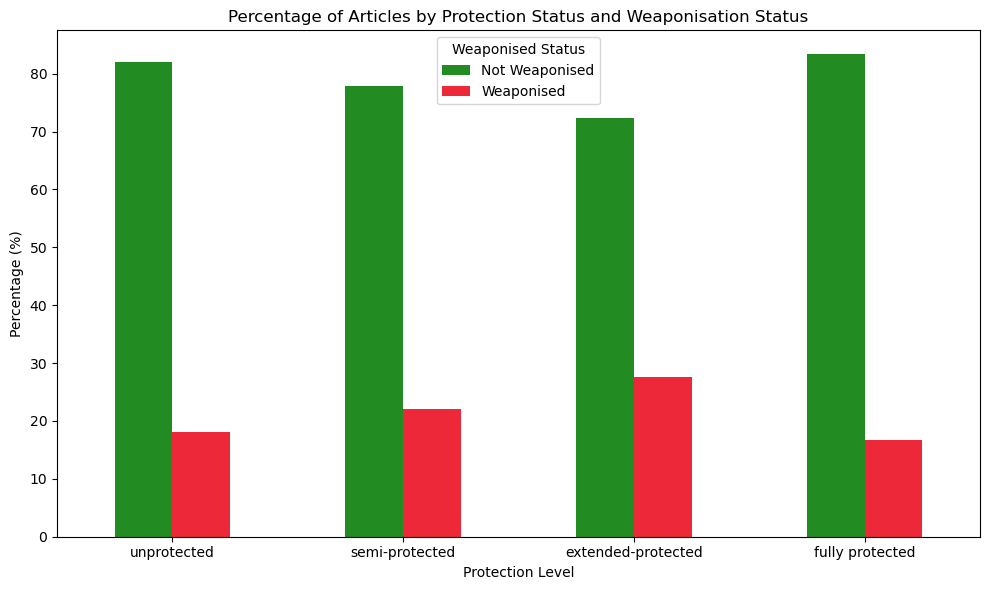

In [96]:
plot_weap_vs_protection(df_match_protect, True, 'percentage')

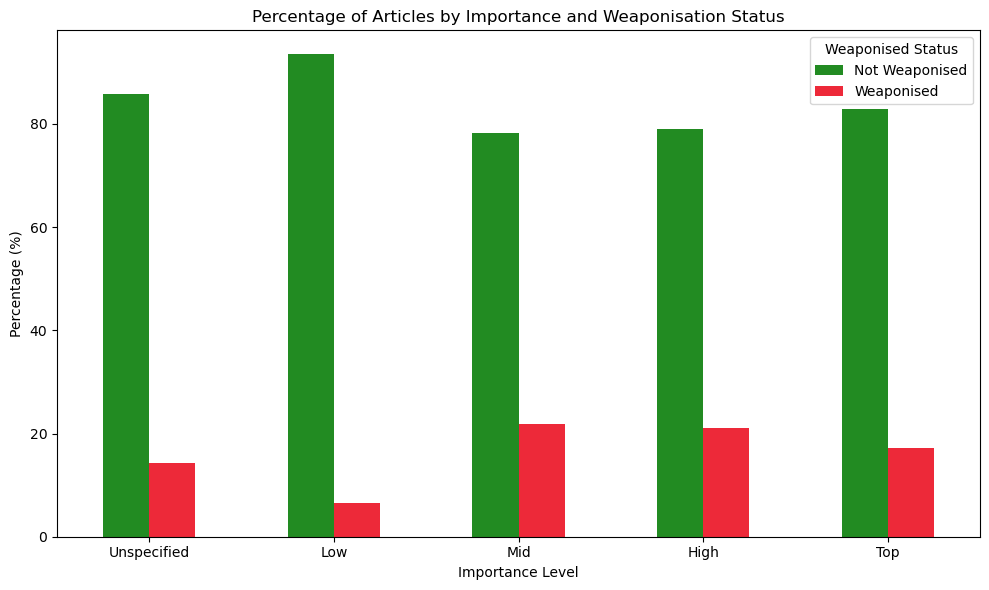

In [97]:
plot_weap_vs_importance(df_final, True, 'percentage')

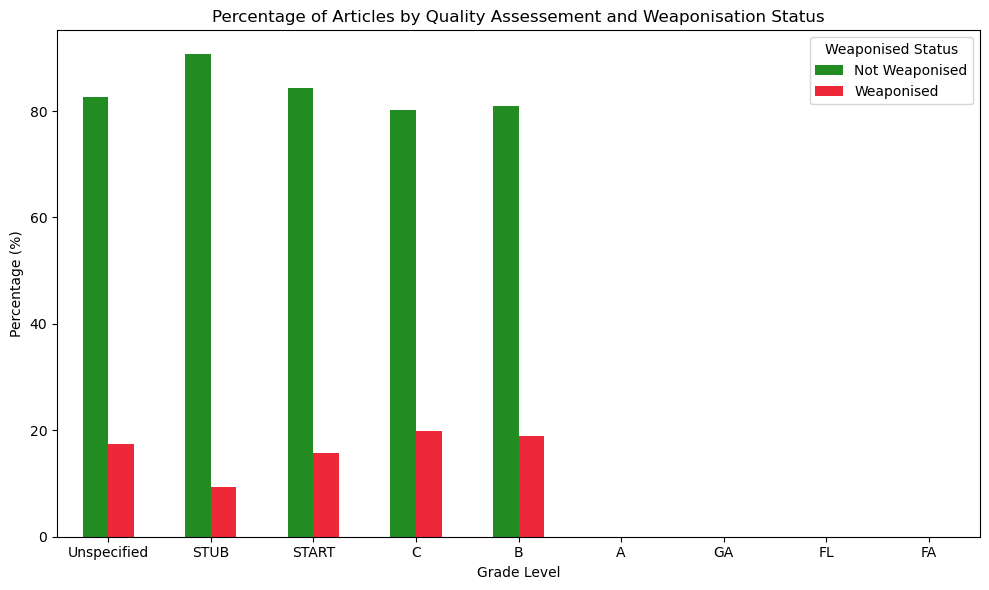

In [98]:
plot_weap_vs_grade(df_final, True, 'percentage')

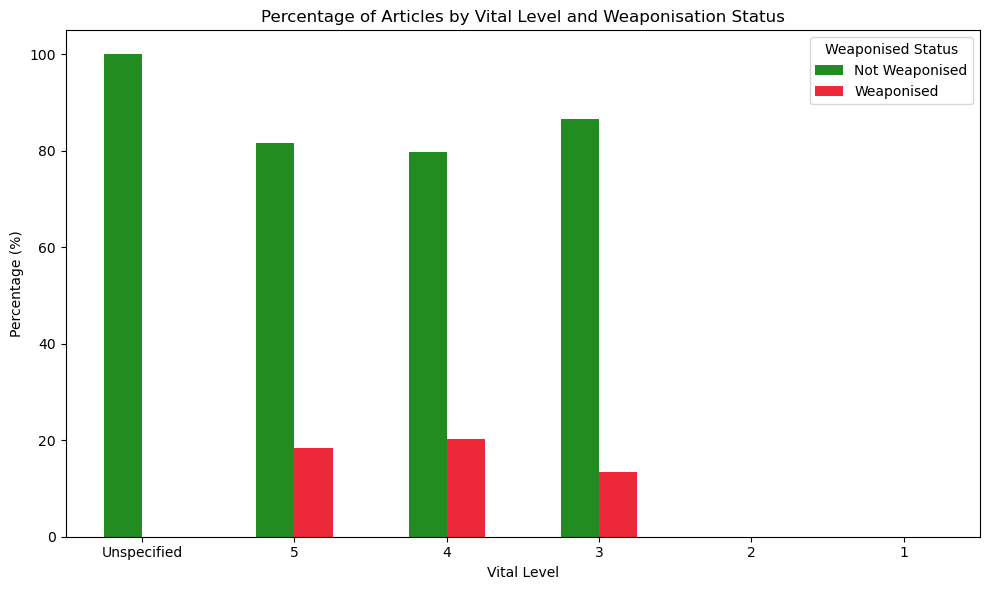

In [99]:
plot_weap_vs_vital(df_final, True, 'percentage')

In [89]:
#df_final[df_final['vital'] == 'Unspecified']
vital_df['article'].unique()

array(['Russian annexation of Crimea', 'Alexander II of Russia',
       'History of Ukraine', 'Euromaidan', ' Galicia (Eastern Europe)',
       'Eastern Front (World War I)', 'Eastern Front (World War II)',
       'Dissolution of the Soviet Union', 'Crimea',
       'Communist Party of the Soviet Union', 'Catherine the Great',
       'Bessarabia'], dtype=object)